In [ ]:
# %% Deep learning - Section 13.133
#    Code challenge 20: MNIST with unequal groups
#    1) Start from code from video 13.132 (mnist dataset)
#    2) Reduce the number of 7s to 500 (random selection) and plot an histogram
#       to confirm it works
#    3) Inspect the digit-specific performance metrics (APRF)
#    4) Before starting, develop an hypothesis of what you might end up seeing;
#       here's mine: since there are fewer samples to extract pattern from, the
#       accuracy should decrease, and the recall (i.e., sensitivity) should also
#       be particularly affected (i.e., a bias towards not recognising 7s that
#       are actually 7s)

# This code pertains a deep learning course provided by Mike X. Cohen on Udemy:
#   > https://www.udemy.com/course/deeplearning_x
# The "base" code in this repository is adapted (with very minor modifications)
# from code developed by the course instructor (Mike X. Cohen), while the
# "exercises" and the "code challenges" contain more original solutions and
# creative input from my side. If you are interested in DL (and if you are
# reading this statement, chances are that you are), go check out the course, it
# is singularly good.


In [3]:
# %% Libraries and modules
import numpy               as np
import matplotlib.pyplot   as plt
import torch
import torch.nn            as nn
import seaborn             as sns
import copy
import torch.nn.functional as F
import pandas              as pd
import scipy.stats         as stats
import sklearn.metrics     as skm
import time

from torch.utils.data                 import DataLoader,TensorDataset
from sklearn.model_selection          import train_test_split
from google.colab                     import files
from torchsummary                     import summary
from IPython                          import display
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')


In [10]:
# %% Function to get the data

# Load data
data_all = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# Function
def get_dataset(digits=None,n_per_digits=None):

    # Remove labels (i.e., numbers IDs) from dataset
    labels = data_all[:,0]
    data   = data_all[:,1:]

    # Normalize to [0,1]
    data_norm = data / np.max(data)

    # Covert to tensor
    data_T   = torch.tensor(data_norm).float()
    labels_T = torch.tensor(labels).long()

    # Split data with scikitlearn
    train_data,test_data, train_labels,test_labels = train_test_split(data_T,labels_T,test_size=0.1)

    # Select subsample
    if digits is not None and n_per_digits is not None:

        keep_indices = np.zeros(labels.shape[0],dtype=bool)
        train_labels_np = train_labels.numpy()

        for lbl in np.unique(train_labels_np):

            idx = np.where(train_labels_np == lbl)[0]

            if lbl in digits:

                idx = np.random.choice(idx,n_per_digits,replace=False)

            keep_indices[idx] = True

        train_data   = train_data[keep_indices]
        train_labels = train_labels[keep_indices]

    # PyTorch datasets
    train_data = TensorDataset(train_data,train_labels)
    test_data  = TensorDataset(test_data,test_labels)

    # DataLoader objects
    batch_size   = 32
    train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

    return train_loader,test_loader


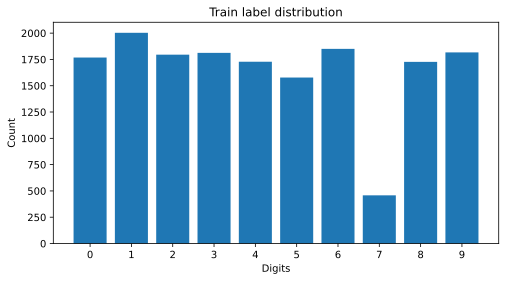

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
# %% Test function

# Call function
train_loader,test_loader = get_dataset(digits=[7],n_per_digits=500)

# Extract train labels
train_labels = train_loader.dataset.tensors[1].numpy()

# Plotting
plt.figure(figsize=(8,4))
plt.hist(train_labels,bins=np.arange(train_labels.min(),train_labels.max()+2)-0.5,rwidth=0.8)
plt.xticks(range(int(train_labels.min()),int(train_labels.max())+1))
plt.xlabel("Digits")
plt.ylabel("Count")
plt.title("Train label distribution")

plt.savefig('figure17_code_challenge_20.png')

plt.show()

files.download('figure17_code_challenge_20.png')


In [15]:
# %% Model class

def gen_model():

    class model(nn.Module):
        def __init__(self):
            super().__init__()

            # Architecture
            self.input  = nn.Linear(784,64 )
            self.hid1   = nn.Linear( 64,32 )
            self.hid2   = nn.Linear( 32,32 )
            self.output = nn.Linear( 32,10 )

        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.hid1(x))
            x = F.relu(self.hid2(x))

            return self.output(x)

    # Model instance, loss function, and optimizer
    ANN       = model()
    loss_fun  = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(ANN.parameters(),lr=0.01)

    return ANN,loss_fun,optimizer


In [16]:
# %% Function to train the model

def train_model():

    # Epochs and fresh model instance
    num_epochs = 10
    ANN,loss_fun,optimizer = gen_model()

    # Preallocate vars
    losses    = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    test_acc  = torch.zeros(num_epochs)

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training data batches
        batch_acc  = []
        batch_loss = []

        for X,y in train_loader:

            # Forward pass, backpropagation, and optimizer step
            yHat = ANN(X)
            loss = loss_fun(yHat,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy from this batch
            batch_loss.append(loss.item())
            batch_acc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

        losses[epoch_i]    = np.mean(batch_loss).item()
        train_acc[epoch_i] = np.mean(batch_acc).item()

        # Test accuracy
        ANN.eval()

        with torch.no_grad():
            X,y = next(iter(test_loader))
            yHat = ANN(X)
            test_acc[epoch_i] = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

        ANN.train()

    return train_acc,test_acc,losses,ANN


In [17]:
# %% Fit the model

train_loader,test_loader = get_dataset(digits=[7],n_per_digits=500)
train_acc,test_acc,losses,ANN = train_model()


In [76]:
# %% Get data to compute performance measures on train and test data

# Predictions for (all) training data (i.e. raw output of last layer)
yHat        = ANN(train_loader.dataset.tensors[0])
train_preds = torch.argmax(yHat,axis=1)
print(train_preds.shape)

# Predictions for test data (i.e. raw output of last layer)
yHat       = ANN(test_loader.dataset.tensors[0])
test_preds = torch.argmax(yHat,axis=1)
print(test_preds.shape)


torch.Size([16176])
torch.Size([1798])


In [77]:
# %% Compute performance measures on train and test data

# Preallocate
train_metrics = np.zeros(4)
test_metrics  = np.zeros(4)

# Training performance measures (accuracy is already an overall measure)
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],(train_preds).float())
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],(train_preds).float(),average='weighted')
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],(train_preds).float(),average='weighted')
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],(train_preds).float(),average='weighted')

# Test performance measures
test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],(test_preds).float())
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],(test_preds).float(),average='weighted')
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],(test_preds).float(),average='weighted')
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],(test_preds).float(),average='weighted')


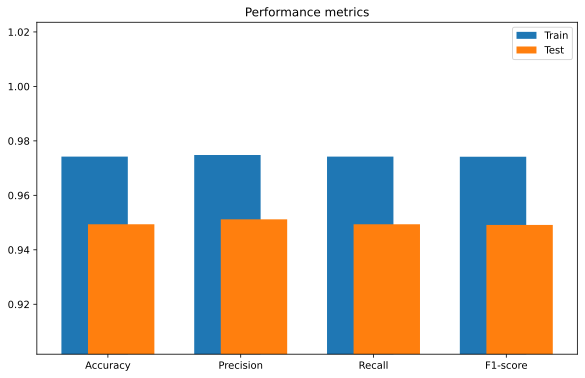

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
# %% Plotting

phi = (1 + np.sqrt(5)) / 2
fig = plt.figure(figsize=(6*phi,6))

plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
ymin = min(train_metrics.min(), test_metrics.min())
ymax = max(train_metrics.max(), test_metrics.max())
plt.ylim([ymin*0.95,ymax*1.05])
plt.legend(['Train','Test'])
plt.title('Performance metrics')

plt.savefig('figure18_code_challenge_20.png')

plt.show()

files.download('figure18_code_challenge_20.png')


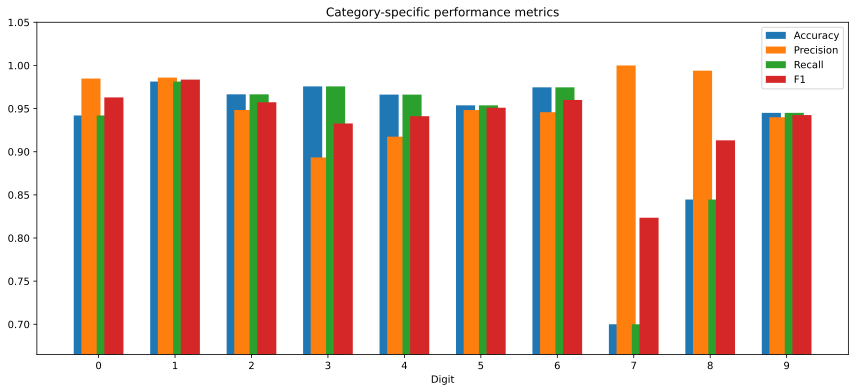

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
# %% Plotting

y_true   = test_loader.dataset.tensors[1].numpy()
y_pred   = test_preds
accuracy = []
for lbl in range(10):
    mask    = (y_true==lbl)
    acc_lbl = (y_pred[mask]==y_true[mask]).float().mean()
    accuracy.append(acc_lbl)

accuracy  = np.array(accuracy)
precision = skm.precision_score(test_loader.dataset.tensors[1],test_preds,average=None)
recall    = skm.recall_score   (test_loader.dataset.tensors[1],test_preds,average=None)
f1_score  = skm.f1_score       (test_loader.dataset.tensors[1],test_preds,average=None)

phi = (1 + np.sqrt(5)) / 2
fig = plt.figure(figsize=(1.5*6*phi,6))

plt.bar(np.arange(10)-.20,accuracy,.25)
plt.bar(np.arange(10)-.10,precision,.25)
plt.bar(np.arange(10)+.10,recall,.25)
plt.bar(np.arange(10)+.20,f1_score,.25)
plt.xticks(range(10),range(10))
ymin = min(accuracy.min(),precision.min(),recall.min(),f1_score.min())
ymax = max(accuracy.min(),precision.max(),recall.max(),f1_score.max())
plt.ylim([ymin*0.95,ymax*1.05])
plt.xlabel('Digit')
plt.legend(['Accuracy','Precision','Recall','F1'])
plt.title('Category-specific performance metrics')

plt.savefig('figure19_code_challenge_20.png')

plt.show()

files.download('figure19_code_challenge_20.png')


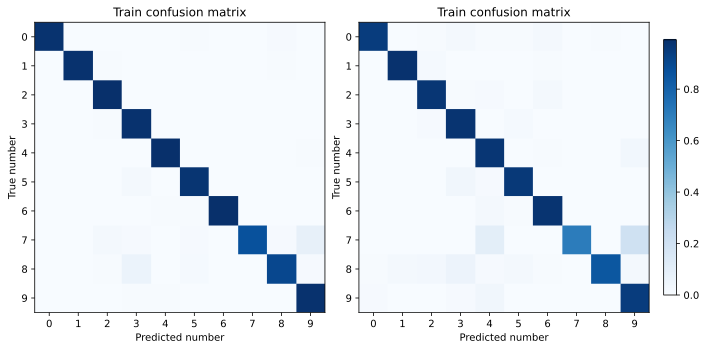

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
# %% Plotting

train_conf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_preds,normalize='true')
test_conf  = skm.confusion_matrix(test_loader.dataset.tensors[1],test_preds,normalize='true')

phi = (1 + np.sqrt(5)) / 2
fig,ax = plt.subplots(1,2,figsize=(phi*6,6),constrained_layout=True)

vmin = min(train_conf.min(),test_conf.min())
vmax = max(train_conf.max(),test_conf.max())

ax[0].imshow(train_conf,'Blues',vmin=vmin,vmax=vmax)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('Train confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

img = ax[1].imshow(test_conf,cmap='Blues',vmin=vmin,vmax=vmax)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('Train confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')
fig.colorbar(img,ax=ax[1],shrink=0.6)

plt.savefig('figure20_code_challenge_20.png')

plt.show()

files.download('figure20_code_challenge_20.png')


In [75]:
# %% Exercise 1
#    The overall and 7-specific performance of the model is still pretty good. What if you reduce the number of 7's to
#    100 instead of 500? What does this tell you about the categorizability of the MNIST set?

# The overall performance is still quite good, while the recall tends to drop
# even more; overall, the categorisability of the MNIST data set seems to be
# quite solid even for unbalanced designs (limited to one class), however, the
# items from the small class tend to be misattributed to other classes, so that
# the model performs good on the "balanced classes", but not on the "unbalanced"
# ones

# Re-run with fewer samples
train_loader,test_loader = get_dataset(digits=[7],n_per_digits=100)
train_acc,test_acc,losses,ANN = train_model()


In [48]:
# %% Exercise 2
#    Perhaps it's still pretty easy to learn the digits when only one category has a small N. In a for-loop, reduce the
#    number of the first 5 digits to N=100, while leaving the other 5 digits at their full sample size. Does that affect
#    model performance?

# Surprisingly or not, the overall performance is still quite good; as for the
# reduced samples, the various metrics do decrease, but differently, some digits
# are more robust while other are more susceptible; my guess (based also on the
# additional exploration from the previous video), is that some digits are
# simply easier to classify, probably because they are written down in a more
# consistent way (e.g., 0, 1) as compared to others (e.g., 3, 4), and
# similarities in digit shapes of course also contribute to wrong classification

# Re-run with fewer samples for more digits (heavily unbalanced design)
train_loader,test_loader = get_dataset(digits=[0,1,2,3,4],n_per_digits=100)
train_acc,test_acc,losses,ANN = train_model()
